On essaye d'optimiser une pipeline pour extraire la lolipop

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys, os
from PIL import Image; print("Classic libs imported")
sys.path.append(os.path.abspath("../../"))
from pipeoptz import Pipeline, Node, IntParameter, PipelineOptimizer; print("pipeline lib imported")
sys.path.append(os.path.abspath("../../../GLACIS-lib_image_analysis/"))
from image_analysis import image_processing, mask_utils, utils, segmentation_workflows; print("image_analysis lib imported") # type: ignore

Classic libs imported
pipeline lib imported
image_analysis lib imported


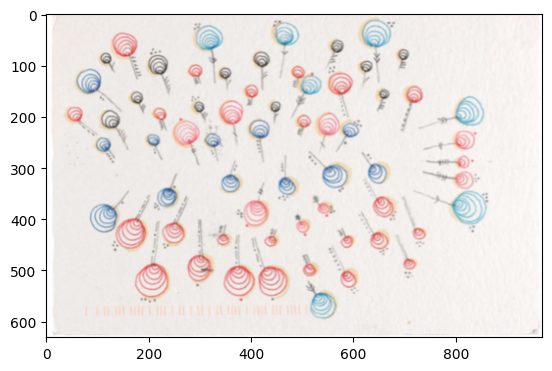

In [2]:
im = np.array(Image.open("../canvas.png"))
plt.imshow(im)

In [4]:
elements = segmentation_workflows.generate_elements(image_path="../../../image/canvas.png")
elements_im = []
for i, el in enumerate(elements):
    elements_im.append(image_processing.min_size(im*el[:,:,np.newaxis]))
plt.imshow(elements[0])

Error: Image not found at ../../../image/canvas.png


IndexError: list index out of range

In [ ]:
p = utils.get_pos(elements[0], bonus=10)
print(p)
plt.imshow(im[p[1]:p[3], p[0]:p[2]])

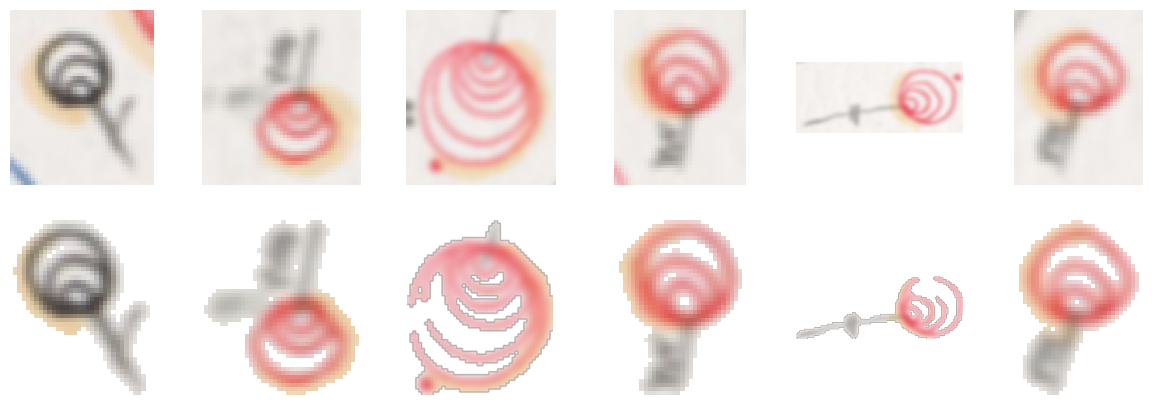

In [5]:
size_training = 6
import random as rd
rd.seed(1)

X = []
y = []
for i in rd.choices(list(range(len(elements))), k=size_training):
    pos = utils.get_pos(elements[i], bonus=5)
    X.append(im[pos[1]:pos[3], pos[0]:pos[2]])
    y.append(elements_im[i])

plt.figure(figsize=(15, 5))
for i in range(size_training):
    plt.subplot(2, size_training, i+1)
    plt.axis('off')
    plt.imshow(X[i])
    plt.subplot(2, size_training, i+1+size_training)
    plt.axis('off')
    plt.imshow(y[i])

In [38]:
from math import comb

def ith_subset(n: int, i: int) -> list[int]:
    """
    Returns the i-th subset of A = [0, n-1], ordered first by cardinality,
    then lexicographically within each cardinality class.

    Args:
        n (int): Upper bound of the interval A = [0, n-1].
        i (int): Index (0 <= i < 2^n) in the cardinality-sorted power set.

    Returns:
        list[int]: The i-th subset under the cardinality-lex order.
    """
    total = 2**n
    if i < 0 or i >= total:
        raise ValueError(f"Index i must be in [0, {total - 1}]")

    # Step 1: find the cardinality group (number of elements in subset)
    remaining = i
    for k in range(n + 1):  # cardinalities from 0 to n
        c = comb(n, k)
        if remaining < c:
            cardinality = k
            break
        remaining -= c

    # Step 2: generate the `remaining`-th k-combination in lex order
    subset = []
    x = 0
    for j in range(cardinality):
        while comb(n-1 - x, cardinality - j - 1) <= remaining:
            remaining -= comb(n-1 - x, cardinality - j - 1)
            x += 1
        subset.append(x)
        x += 1

    return subset

def integer(n):
    return n

def to_mask(image):
    return image[:,:,3] != 0

def biggest_mask(elements):
    size = []
    if len(elements) != 0:
        for el in elements:
            size.append(el.sum())
        return elements[size.index(max(size))]
    else:
        return None

def colored_mask(image, mask):
    if mask is not None:
        return image*mask[:,:,np.newaxis]
    else:
        return np.zeros(shape=image.shape)

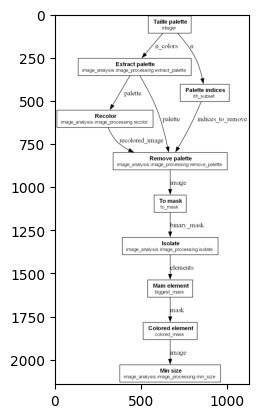

In [39]:
p = Pipeline("Lolipop optimization")
p.add_node(Node("Taille palette", integer, fixed_params={"n":8}))
p.add_node(Node("Extract palette", image_processing.extract_palette), predecessors={"image":"run_params:image", "n_colors":"Taille palette"})
p.add_node(Node("Palette indices", ith_subset, fixed_params={"i": 37}), predecessors={"n":"Taille palette"})
p.add_node(Node("Recolor", image_processing.recolor), predecessors={"image":"run_params:image", "palette":"Extract palette"})
p.add_node(Node("Remove palette", image_processing.remove_palette), predecessors={"image":"run_params:image", "recolored_image":"Recolor", "palette":"Extract palette", "indices_to_remove":"Palette indices"})
p.add_node(Node("To mask", to_mask), predecessors={"image":"Remove palette"})
p.add_node(Node("Isolate", mask_utils.isolate), predecessors={"binary_mask": "To mask"})
p.add_node(Node("Main element", biggest_mask), predecessors={"elements":"Isolate"})
p.add_node(Node("Colored element", colored_mask), predecessors={"image":"run_params:image", "mask":"Main element"})
p.add_node(Node("Min size", image_processing.min_size), predecessors={"image":"Colored element"})

p.to_dot(filepath="lolipop.dot", generate_png=True)
plt.imshow(Image.open("lolipop.png"))

In [114]:
import numpy as np

def sliding_iou(im1, im2):
    if np.prod(im1.shape[:2]) < np.prod(im2.shape[:2]):
        small, large = im1[:,:,3], im2[:,:,3]
    else:
        small, large = im2[:,:,3], im1[:,:,3]
    sh, sw = small.shape
    lh, lw = large.shape

    best_iou = 0.0
    for y in range(lh - sh + 1):
        for x in range(lw - sw + 1):
            crop = large[y:y+sh, x:x+sw]
            intersection = np.logical_and(small, crop).sum()
            union = np.logical_or(small, crop).sum()
            iou = intersection / union if union != 0 else 0.0
            if iou > best_iou:
                best_iou = iou
    return best_iou

def loss(im1, im2):
    return 1/(sliding_iou(im1, im2)+1)


In [116]:
X2 = []
for x in X:
    X2.append({"image":x})

po = PipelineOptimizer(p, loss, 10, X2, y)
po.add_param(IntParameter("Taille palette", "n", 6, 10))
po.add_param(IntParameter("Palette indices", "i", 1, 63))

{'Taille palette.n': np.int64(10), 'Palette indices.i': np.int64(56)}


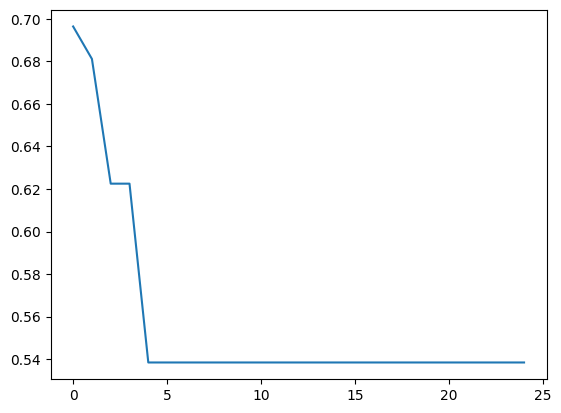

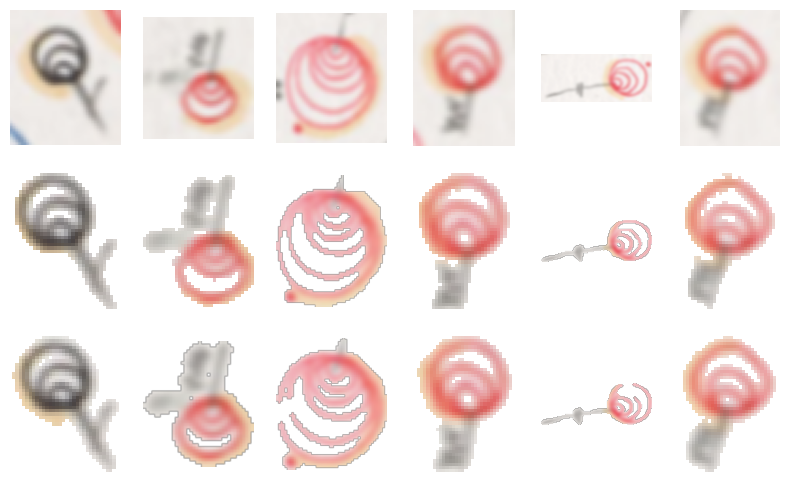

In [117]:
bp = po.optimize("ACO", iterations=25, ants=5, verbose=True)
plt.plot(bp[1])

plt.figure(figsize=(10,6))
for i in range(size_training):
    plt.subplot(3,size_training,i+1)
    plt.axis('off')
    plt.imshow(X[i])
    id, res, t = p.run(run_params={"image":X[i]}, optimize_memory=True)
    plt.subplot(3, size_training, i+1+size_training)
    plt.axis('off')
    plt.imshow(res[id])
    plt.subplot(3, size_training, i+1+size_training*2)
    plt.axis('off')
    plt.imshow(y[i])

print(bp[0])

{'Taille palette.n': 6, 'Palette indices.i': 7}


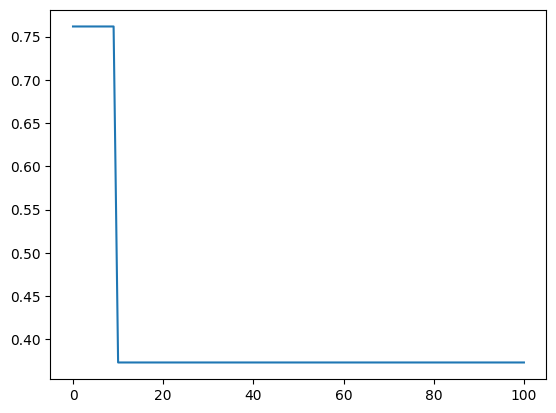

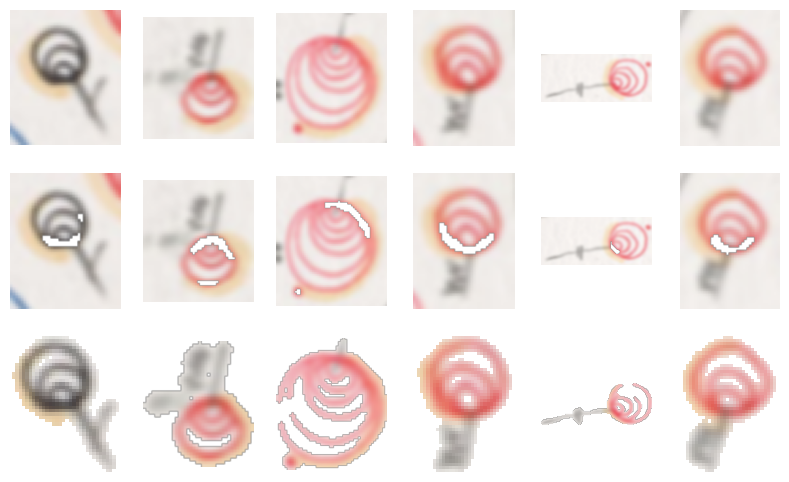

In [98]:
bp = po.optimize("SA", iterations=100, verbose=True)
plt.plot(bp[1])

plt.figure(figsize=(10,6))
for i in range(size_training):
    plt.subplot(3,size_training,i+1)
    plt.axis('off')
    plt.imshow(X[i])
    id, res, t = p.run(run_params={"image":X[i]}, optimize_memory=True)
    plt.subplot(3, size_training, i+1+size_training)
    plt.axis('off')
    plt.imshow(res[id])
    plt.subplot(3, size_training, i+1+size_training*2)
    plt.axis('off')
    plt.imshow(y[i])

print(bp[0])

{'Taille palette.n': 10, 'Palette indices.i': 56}


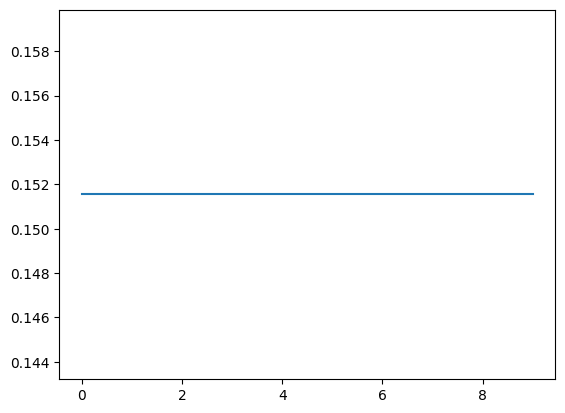

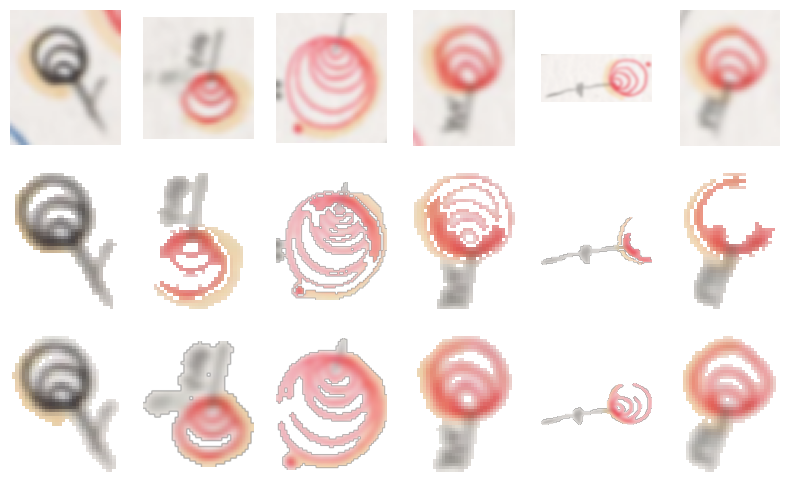

In [99]:
bp = po.optimize("PSO", iterations=10, verbose=True)
plt.plot(bp[1])

plt.figure(figsize=(10,6))
for i in range(size_training):
    plt.subplot(3,size_training,i+1)
    plt.axis('off')
    plt.imshow(X[i])
    id, res, t = p.run(run_params={"image":X[i]}, optimize_memory=True)
    plt.subplot(3, size_training, i+1+size_training)
    plt.axis('off')
    plt.imshow(res[id])
    plt.subplot(3, size_training, i+1+size_training*2)
    plt.axis('off')
    plt.imshow(y[i])

print(bp[0])

{'Taille palette.n': 10, 'Palette indices.i': 19}


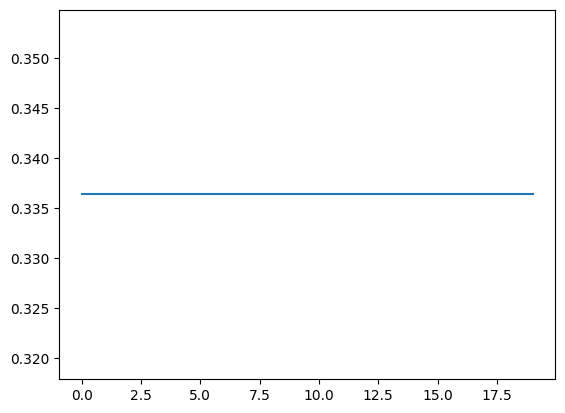

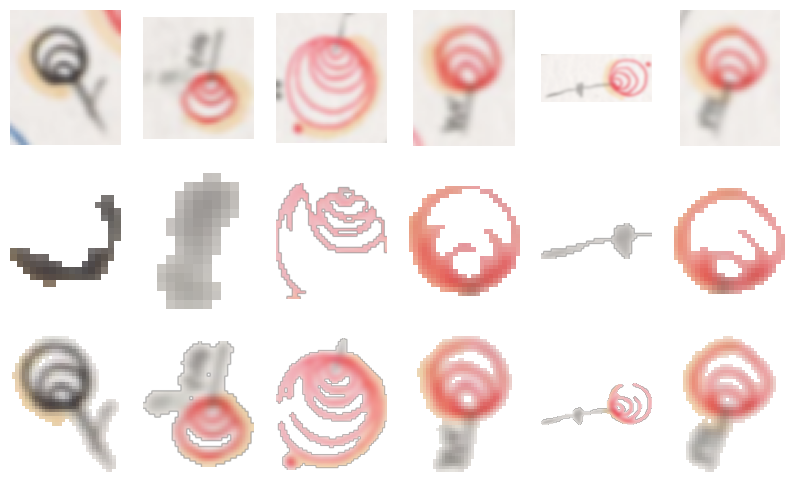

In [100]:
bp = po.optimize("GA", generations=20, population_size=10, verbose=True)
plt.plot(bp[1])

plt.figure(figsize=(10,6))
for i in range(size_training):
    plt.subplot(3,size_training,i+1)
    plt.axis('off')
    plt.imshow(X[i])
    id, res, t = p.run(run_params={"image":X[i]}, optimize_memory=True)
    plt.subplot(3, size_training, i+1+size_training)
    plt.axis('off')
    plt.imshow(res[id])
    plt.subplot(3, size_training, i+1+size_training*2)
    plt.axis('off')
    plt.imshow(y[i])

print(bp[0])

Iteration 315/500
{'Taille palette.n': 10, 'Palette indices.i': 56}


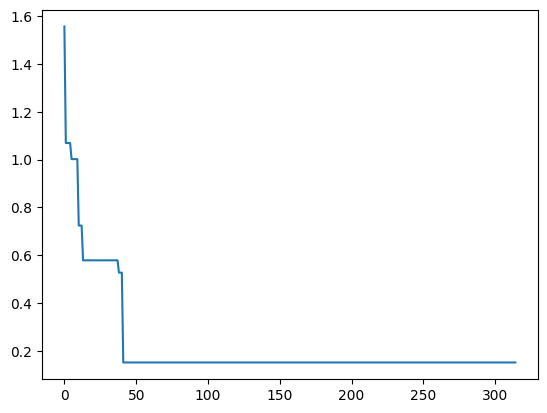

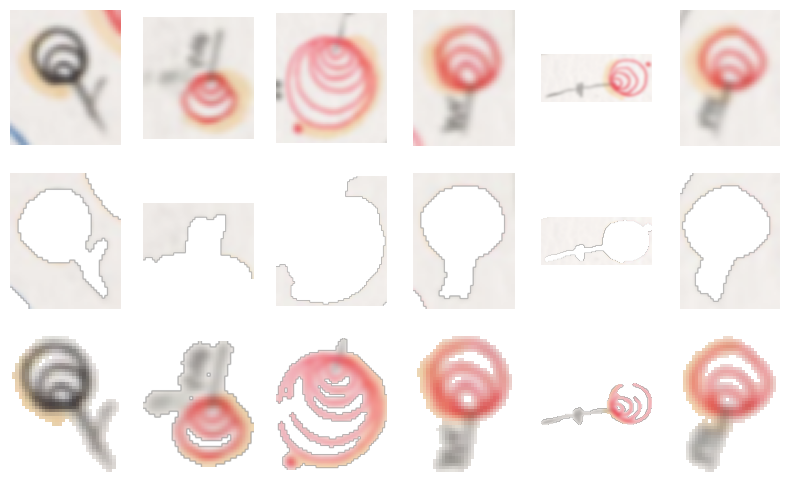

In [101]:
bp = po.optimize("grid_search", max_combinations=500, verbose=True)
print()
plt.plot(bp[1])

plt.figure(figsize=(10,6))
for i in range(size_training):
    plt.subplot(3,size_training,i+1)
    plt.axis('off')
    plt.imshow(X[i])
    id, res, t = p.run(run_params={"image":X[i]}, optimize_memory=True)
    plt.subplot(3, size_training, i+1+size_training)
    plt.axis('off')
    plt.imshow(res[id])
    plt.subplot(3, size_training, i+1+size_training*2)
    plt.axis('off')
    plt.imshow(y[i])

print(bp[0])

Iteration 25/25
{'Taille palette.n': 9, 'Palette indices.i': 17}


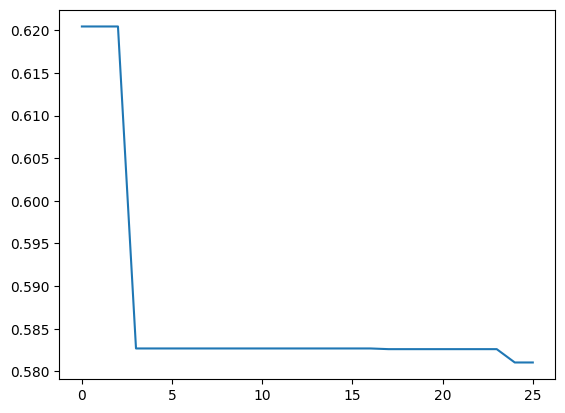

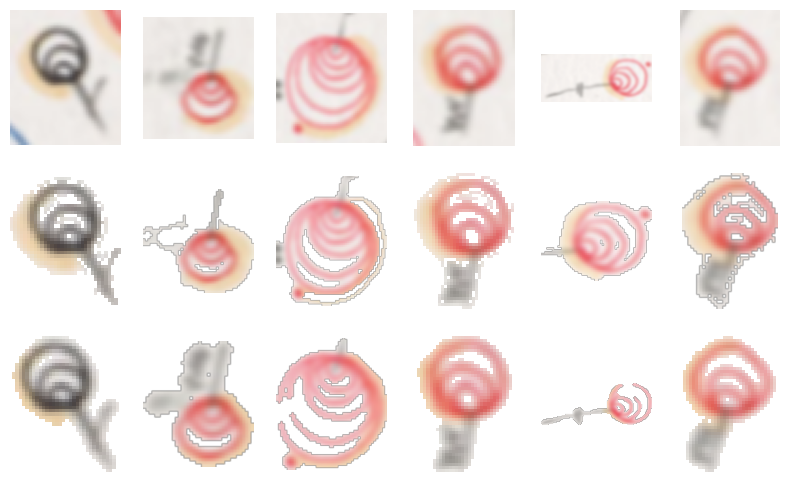

In [136]:
bp = po.optimize("BO", iterations=25, init_points=10, verbose=True)
print()
plt.plot(bp[1])

plt.figure(figsize=(10,6))
for i in range(size_training):
    plt.subplot(3,size_training,i+1)
    plt.axis('off')
    plt.imshow(X[i])
    id, res, t = p.run(run_params={"image":X[i]}, optimize_memory=True)
    plt.subplot(3, size_training, i+1+size_training)
    plt.axis('off')
    plt.imshow(res[id])
    plt.subplot(3, size_training, i+1+size_training*2)
    plt.axis('off')
    plt.imshow(y[i])

print(bp[0])